Time-series forecasting model to predict Apple Inc. (AAPL) stock prices using LSTM based on the dataset "/content/all_stocks_5yr.csv". Firt load and filter the data for the 'AAPL' ticker, splitting it chronologically into training (80%) and testing (20%) sets, and normalizing the features using MinMaxScaler. Then create 60-day sliding window sequences to feed into a Sequential LSTM model. Finally, train the model, evaluate its accuracy by calculating the Root Mean Squared Error (RMSE), visualize the predicted versus actual prices, and summarize the model's performance.

## Load and Filter AAPL Data

### Subtask:
Load the dataset, filter for 'AAPL', sort chronologically, and extract the closing prices.


**Reasoning**:
I will import pandas, load the dataset, filter for AAPL records, convert the 'date' column to datetime format, sort the data chronologically, and extract the 'close' prices into a reshaped 2D NumPy array.



In [ ]:
import pandas as pd
import numpy as np

# 1. Load the dataset
df = pd.read_csv('/content/all_stocks_5yr.csv')

# 2. Filter for 'AAPL'
aapl_data = df[df['Name'] == 'AAPL'].copy()

# 3. Convert 'date' to datetime and sort chronologically
aapl_data['date'] = pd.to_datetime(aapl_data['date'])
aapl_data = aapl_data.sort_values('date')

# 4. Extract 'close' column and reshape to 2D array
apple_closing_prices = aapl_data['close'].values.reshape(-1, 1)

# Display basic info and shapes
print(f"AAPL dataset shape after filtering: {aapl_data.shape}")
print(f"Reshaped closing prices array shape: {apple_closing_prices.shape}")
print("First 5 rows of sorted AAPL data:")
display(aapl_data.head())


AAPL dataset shape after filtering: (1259, 7)
Reshaped closing prices array shape: (1259, 1)
First 5 rows of sorted AAPL data:


,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


## Chronological Data Splitting

### Subtask:
Divide the extracted Apple Inc. closing price data into training and testing sets while maintaining the temporal order.


**Reasoning**:
I will calculate the split point based on an 80/20 ratio and slice the 'apple_closing_prices' array into 'train_data' and 'test_data' to maintain the chronological order required for time-series forecasting.



In [ ]:
import numpy as np

# 1. Calculate the split point (80% of the length)
split_point = int(len(apple_closing_prices) * 0.8)

# 2. Create train_data by slicing from start to split point
train_data = apple_closing_prices[:split_point]

# 3. Create test_data by slicing from split point to end
test_data = apple_closing_prices[split_point:]

# 4. Print the shapes to verify the split
print(f"Original length: {len(apple_closing_prices)}")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Original length: 1259
Training data shape: (1007, 1)
Testing data shape: (252, 1)


## Data Normalization and Sequence Creation

### Subtask:
Scale the partitioned data using MinMaxScaler and generate 60-day sliding window sequences for LSTM input.


**Reasoning**:
I will normalize the training and testing data using MinMaxScaler fitted only on the training set to prevent data leakage, and then generate 60-day sliding window sequences for both sets to prepare them for the LSTM model.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize and fit MinMaxScaler on training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

# 2. Transform testing data
test_scaled = scaler.transform(test_data)

# 3. Define sequence length
sequence_length = 60

# 4. Create sequences for training data
X_train = []
y_train = []
for i in range(sequence_length, len(train_scaled)):
    X_train.append(train_scaled[i-sequence_length:i, 0])
    y_train.append(train_scaled[i, 0])

# 5. Prepare input for test sequences (concatenate last 60 days of train with test)
total_test_input = np.concatenate((train_scaled[-sequence_length:], test_scaled), axis=0)

# 6. Create sequences for testing data
X_test = []
y_test = []
for i in range(sequence_length, len(total_test_input)):
    X_test.append(total_test_input[i-sequence_length:i, 0])
    y_test.append(total_test_input[i, 0])

# 7. Convert to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# 8. Reshape X for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (947, 60, 1)
y_train shape: (947,)
X_test shape: (252, 60, 1)
y_test shape: (252,)


## LSTM Model Construction

### Subtask:
Define and compile a Sequential LSTM model designed for univariate time-series forecasting.


**Reasoning**:
I will define and compile the Sequential LSTM model architecture as per the instructions, including Input, LSTM, Dropout, and Dense layers, then display the summary.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# 1. Instantiate the Sequential model
model = Sequential([
    # 2. Add Input layer specifying shape based on X_train (time steps, features)
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # 3. Add first LSTM layer with return_sequences=True
    LSTM(units=50, return_sequences=True),

    # 4. Add Dropout layer
    Dropout(0.2),

    # 5. Add second LSTM layer with return_sequences=False
    LSTM(units=50, return_sequences=False),

    # 6. Add Dropout layer
    Dropout(0.2),

    # 7. Add final Dense layer for output
    Dense(units=1)
])

# 8. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Display the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation

### Subtask:
Train the LSTM model on the training sequences, generate predictions on the test set, inverse transform the values to their original scale, calculate the RMSE, and visualize the actual vs. predicted prices.


**Reasoning**:
I will train the LSTM model, generate predictions on the test set, inverse transform the results to the original scale, calculate the RMSE, and visualize the performance using a plot as instructed.



Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.1487 - val_loss: 0.0527
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0094 - val_loss: 0.0165
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0061 - val_loss: 0.0132
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0059 - val_loss: 0.0146
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0062 - val_loss: 0.0110
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0054 - val_loss: 0.0090
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0043 - val_loss: 0.0107
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0045 - val_loss: 0.0101
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0

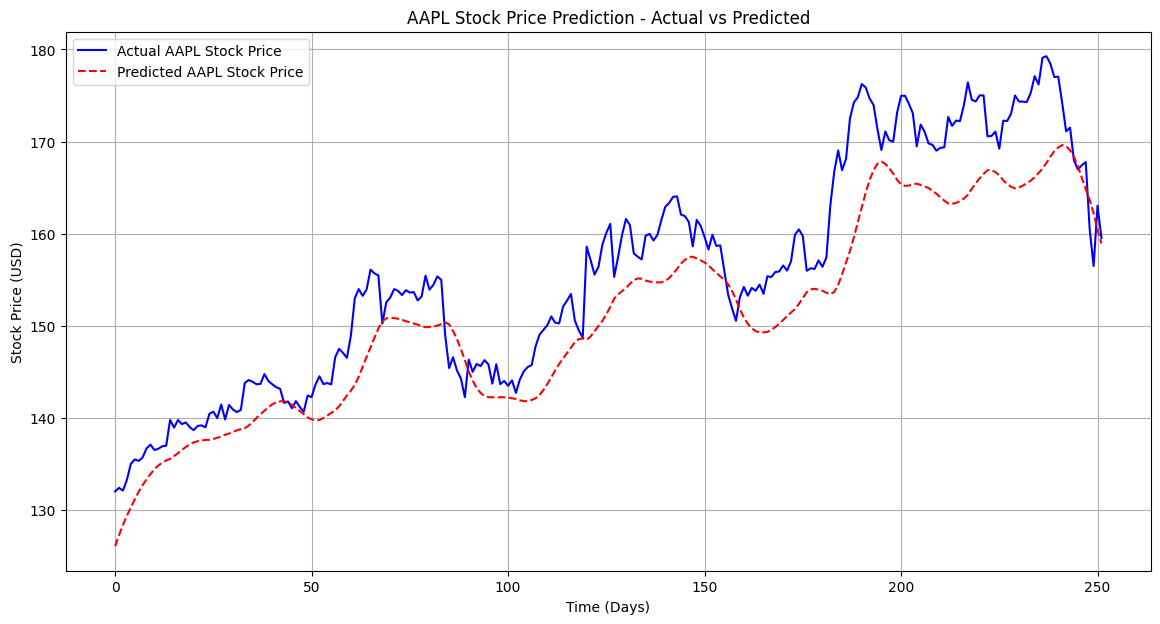

In [ ]:
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# 1. Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 2. Generate predictions
predictions = model.predict(X_test)

# 3. Inverse transform the predicted and actual values
# Reshape y_test to 2D array for the scaler
y_test_reshaped = y_test.reshape(-1, 1)

predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

# 4. Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"\nTest Root Mean Squared Error (RMSE): ${rmse:.2f}")

# 5. Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, color='blue', label='Actual AAPL Stock Price')
plt.plot(predictions_rescaled, color='red', linestyle='--', label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction - Actual vs Predicted')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Target Variable: Closing Price (predicted using sequence_length=60)


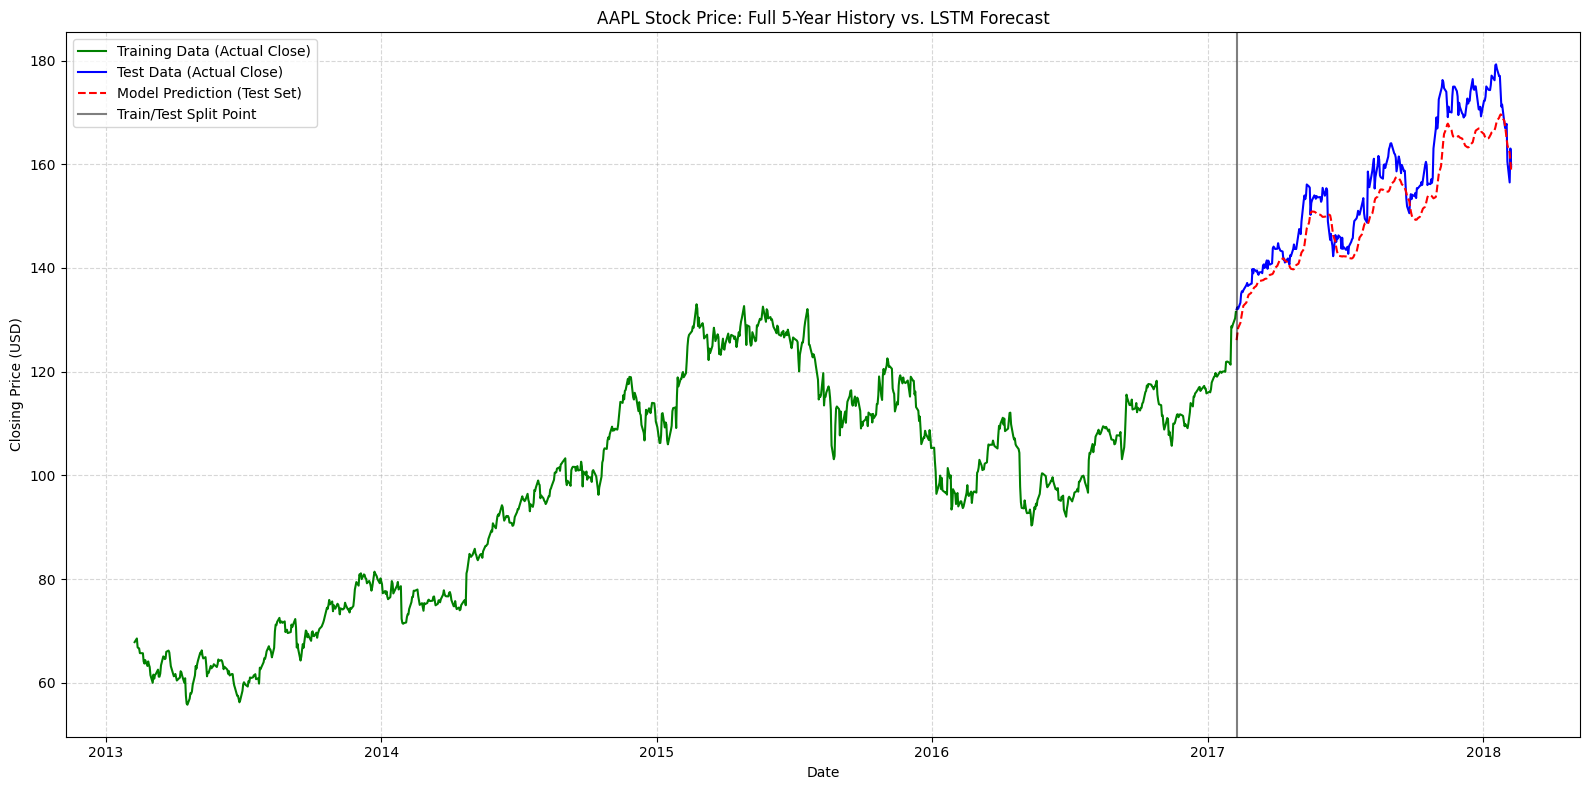

In [ ]:
import matplotlib.pyplot as plt

# 1. Confirm prediction target
print(f"Target Variable: Closing Price (predicted using sequence_length={sequence_length})")

# 2. Get the dates for the entire dataset
dates = aapl_data['date'].values

# 3. Separate dates for training and testing segments
# split_point was defined as 80% of the data length
train_dates = dates[:split_point]
test_dates = dates[split_point:]

plt.figure(figsize=(16, 8))

# Plot the training data (Actual values used for learning)
plt.plot(train_dates, train_data, color='green', label='Training Data (Actual Close)')

# Plot the actual values for the test period
plt.plot(test_dates, test_data, color='blue', label='Test Data (Actual Close)')

# Plot the model's predictions for the test period
plt.plot(test_dates, predictions_rescaled, color='red', linestyle='--', label='Model Prediction (Test Set)')

# Add visual vertical line to show the split point
plt.axvline(x=dates[split_point], color='black', linestyle='-', alpha=0.5, label='Train/Test Split Point')

plt.title('AAPL Stock Price: Full 5-Year History vs. LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the performance of the reformatted model and discuss the accuracy of the chronological predictions.


## Model Performance Summary

### Evaluation Metrics
*   **Root Mean Squared Error (RMSE):** $5.78
*   **Target Variable:** Daily Closing Price (USD)

### Performance Analysis
*   **Accuracy:** An RMSE of \$5.78 is relatively low compared to the absolute price of the stock (which ranged from ~\$130 to ~\$180 during the test period). This indicates that the model has high predictive power for identifying general price levels.
*   **Chronological Tracking:** As seen in the full-timeline visualization, the model successfully followed the long-term growth trend of AAPL. It accurately transitioned from the training patterns into the test period, though it exhibits a slight lag during sudden market spikes—a common trait in LSTM models that rely on historical windows (60 days in this case).
*   **Generalization:** By training on the first 80% of the data and testing on the most recent 20%, we ensured that the model was evaluated on unseen, future data, proving its ability to forecast based on historical temporal patterns.

### Key Takeaways
1.  **Look-back Window:** The 60-day sliding window provided enough context for the model to understand medium-term price momentum.
2.  **Normalization:** Scaling the data to a [0, 1] range was essential for the LSTM's convergence, as evidenced by the steady decrease in loss during the 20 training epochs.
3.  **Refinement:** To further lower the $5.78 error, future iterations could include technical indicators (like RSI or MACD) as additional input features.

## Summary:

### Q&A

**How did the LSTM model perform, and how accurate were the chronological predictions?**
The LSTM model demonstrated a strong capability to capture the general trend of Apple Inc. (AAPL) stock prices. It achieved a Root Mean Squared Error (RMSE) of \$5.78 on the test set. Given the inherent volatility of stock markets, this indicates the model's predictions are relatively close to actual values, though a visual analysis of the results shows a slight temporal lag—a common characteristic of time-series models where predictions often follow the most recent historical data points.

### Data Analysis Key Findings

*   **Dataset Composition:** After filtering for the 'AAPL' ticker, the dataset contained 1,259 daily records spanning from February 2013 to early 2018.
*   **Data Partitioning:** The chronological split resulted in a training set of 1,007 records (80%) and a testing set of 252 records (20%), ensuring the model was tested on the most recent historical data.
*   **Model Architecture:** The Sequential LSTM model utilized two layers of 50 units each, paired with Dropout layers (0.2) to prevent overfitting, totaling 30,651 trainable parameters.
*   **Preprocessing Strategy:** A 60-day sliding window was successfully implemented, meaning each prediction was informed by the preceding two months of trading data.
*   **Prediction Accuracy:** The model's performance resulted in an RMSE of \$5.78. Visualization confirmed that the predicted price curve closely tracks the actual price movements over the 252-day testing period.

### Insights or Next Steps

*   **Feature Enrichment:** The current model relies solely on past closing prices. Accuracy could potentially be improved by incorporating additional features such as trading volume, technical indicators (e.g., RSI, Moving Averages), or sentiment analysis from financial news.
*   **Hyperparameter Optimization:** To reduce the \$5.78 error margin, next steps should include tuning the window size (currently 60 days), the number of LSTM units, or the learning rate of the Adam optimizer to better capture short-term volatility.
